### Syfte
Jag ämnar träna en modell för att prediktera 5 tänkbara värden till attributet "Keywords" för en Friluftsprodukt i ett PIM-system. 

### Bakgrund

Jag arbetar med masterdata i PIM-system (Product Information Management) inom detaljhandeln. Jag arbetar i gruppen som samlar in och berikar upp nya produkter som kommer säljas på vår hemsida. Varje produkt har en uppsättning attribut som ska berikas upp med värden. Många av dessa attributs värden ska samlas in från tillverkarna eller distributören. Medans andra attribut ska berikas upp med värden som baserar sig på den insamlade och bearbetade produktinformationen. Ett av dessa attribut är Keywords. För varje produkt måste minst 1 keyword väljas. Det finns inget maxtak för antalet, utan det är relevansen som avgör.

Mitt mål med modelleringen är att träna en modell för att göra prediktioner på vilka Keywords som skulle kunna passa produkten. När modellen sätts i produktion ska den föreslå de 5 mest relevanta keywordsen för respektive produkt. 
Om den bedöms som tillräckligt bra och pålitlig kommer den att implementeras in i ett Django projekt som ska hjälpa produktberikarna med flera olika slags automatiserade flöden. 

### Problemformulering

Det är ett klassificeringsproblem. Jag började arbetet utifrån antagandet att det handlade om Multiklass klassificering. Men jag insåg under processen att varje Keyword kan passa för flera olika texter och började då om utifrån att det handlade om ett MultiLabel problem. Målet med prediktionen är att returnera en lista med 5 keywords. Optimeringen och utvärderingen syftar till att avgöra hur bra modellen är på att föreslå relevanta alternativ utifrån en ranking där de 5 bästa alternativen returneras.

### Översikt av ML-projektet

Data hämtas av mig direkt i PIM och exporteras ut som en csv-fil med ";" som separator.

Min beroende variabel är **Keywords**, och det som modellen ska prediktera. 

Min tanke är att använda Label-encoding för att omvandla Keywordet till kategorisk data. Det handlar om flera hundra olika keywords som vi kommer att se senare i EDA:n. Därav valet av Label-encoding. 
Och modellen kommer vara en multilabel klassificerare, där varje produkt kan ha en eller flera keywords.

De oberoende variablerna jag kommer använda mig av från början är: 

**iPIM Classification [iPIM]** - Textsträng, men det finns ett givet antal och jag använder Label-encoding.

**SEO-Keyword** - Textsträng, men det finns ett givet antal och jag använder Label-encoding.

**"Headline"** - Textsträng med ca 50-75 tecken.

**"Short text"** - Textsträng med ca 180-220 tecken.

**"Long Text"** - Textsträng med ca 300-450 tecken. 

För dessa textsträngar kommer jag använda mig av "Bag of Words" och metoden TfidfTransformer i scikit-learn och omvandla dem till kategorisk data. 

Kolumnen "Product number" är id:numret för produkten. "Name" är produktnamnet. Dessa behövs inte vid modellträningen då de inte är relevanta för val av keywords. Kanske som identifikator för att mänskligt kunna bedöma om det prediktiga sökordet är relevant.


#### Importer

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [167]:
raw_df = pd.read_csv(("keyword_adder/resources/dataset_keywords_swe.csv"), encoding="utf-8", delimiter=";")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10072 entries, 0 to 10071
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Product number              10072 non-null  int64 
 1   Name                        10072 non-null  object
 2   Keywords                    10072 non-null  object
 3   SEO-Keyword                 9957 non-null   object
 4   Short Text                  10067 non-null  object
 5   Long Text                   9668 non-null   object
 6   Headline                    8475 non-null   object
 7   iPIM Classification [iPIM]  10072 non-null  object
dtypes: int64(1), object(7)
memory usage: 629.6+ KB


### Databearbetning

In [168]:
cleaned_df = raw_df[["Keywords", "SEO-Keyword", "Short Text", "Long Text", "Headline", "iPIM Classification [iPIM]"]].dropna().copy()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8220 entries, 0 to 10071
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Keywords                    8220 non-null   object
 1   SEO-Keyword                 8220 non-null   object
 2   Short Text                  8220 non-null   object
 3   Long Text                   8220 non-null   object
 4   Headline                    8220 non-null   object
 5   iPIM Classification [iPIM]  8220 non-null   object
dtypes: object(6)
memory usage: 449.5+ KB


In [169]:
cleaned_df.head()

,Keywords,SEO-Keyword,Short Text,Long Text,Headline,iPIM Classification [iPIM]
0,Cykelbyxor med vaddering | Cykelunderkläder | ...,Vadderade cykelbyxor,<p>När det fortfarande är kallt på morgonens t...,<p>När det är svalt och torrt ger dig Gore C3 ...,Rätt mängd värme för svala dagar,Bike Trousers [BikeTrousers]
2,Livsstilsböcker om friluftsliv,Reseguide,<p>Den här boken tar ett samlat grepp om frilu...,<p>De flesta av bokens turer kan du göra på en...,Upplev friluftslivet kring Kungsbacka,Guide Books [GuideBooks]
5,Vandringsbyxor för vinter,Jaktbyxor,<p>Bekväm och varm jaktbyxa i G-1000 Silent Ec...,<p>Sydd i vind- och vattenavvisande G-Silent E...,Mångsidig jaktbyxa från Fjällräven,Trouser [Trouser]
7,3-säsongs vandringsbyxor | Syntetiskt material,Vandringsbyxor,<p>Sköna softshellbyxor som passar för vandrin...,<p><b>I korthet</b></p>\n\n<ul>\n<li>Softshell...,Vandringsbyxor från The North Face,Trouser [Trouser]
8,Vintertält | 3-säsongs tält,Kupoltält,<p>Robust kupoltält med självstagande konstruk...,<p>Hilleberg Saivo är ett kupoltält designat f...,Stabilt och rymligt 4-säsongstält,Dome Tents [DomeTents]


#### Hantering av Keywords
I och med att varje fält i Keywords kan bestå av mer än ett keyword så är frågan hur jag ska hantera det.
Jag skulle kunna använda Explode i pandas, vilket skulle dela upp keywords ut på egna rader. 
Men det skapar kommer skapa dubletter och det blir inte helt rätt. Om mitt mål var att sätta endast ett keyword per produkt, så skulle multiklass klassificerare vara rimlig. Men nu vill jag få en lista med upp till 5 möjliga keywords, och då är flera klasser möjliga.

Efter research bland annat på geeksforgeeks och scikitlearn är nog en multilabel approach bättre för mitt syfte och jag fortsätter med den.


#### Hantering av Keywordet "Klassiskt friluftsliv"
"Klassiskt friluftsliv" är ett ord som använts som ifyllnad för produkter som saknade Keyword inför en migrering under våren 2025.
Jag tar bort rader från cleaned_df där värdet är "Klassiskt friluftsliv" i kolumnen Keywords.

Det fanns inga rader med endast det Keywordet, och antalet förekomster av det var förhållandevis litet. Jag går vidare utan åtgärd.

In [170]:
# Finns det rader där Keywords endast innehåller "Klassiskt friluftsliv"?
only = (cleaned_df["Keywords"].str.strip() == "Klassiskt friluftsliv").sum()
anywhere = cleaned_df["Keywords"].str.contains("Klassiskt friluftsliv", regex=False, na=False).sum()

print("Unikt förekommande:", only)
print("Förekommer någonstans:", anywhere)

Unikt förekommande: 0
Förekommer någonstans: 75


#### Analys av outliers
Med multilabel klassificering är kanske inte rader innehållandes ett enda keyword ett problem. Det är snarare helt rimligt för det här datasetet. Det som skulle kunna störa är det Placeholder ordet "Klassiskt friluftsliv", som jag redan kollat, eller om någon eller flera produkter sticker ut väldigt mycket. Och det gör jag nog bäst med att räkna antalet keywords för varje produkt. 

Det finns också många keywords som inte används så speciellt ofta, jag analyserar också dessa genom att använda pd.explode.

Efter analysen såg jag att mina outliers snarare fanns inbäddade i Keywords, och genom att räkna förekomsten av dessa tog jag bort keywords som används färre än 20 gånger.

In [171]:
# Räknar antalet keywords för varje produkt och skapar en ny kolumn, kw_count, där antalet kommer anges med en siffra.
cleaned_df["kw_count"] = (
    cleaned_df["Keywords"]
    .str.split("|")
    .apply(lambda x: len([kw.strip() for kw in x if kw.strip() != ""]))
)    

# Använder describe för att få en uppfattning om antalet    
print(cleaned_df["kw_count"].describe())
print(cleaned_df["kw_count"].value_counts().sort_index())

count    8220.000000
mean        1.983577
std         1.139005
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: kw_count, dtype: float64
kw_count
1    3538
2    2532
3    1327
4     531
5     188
6      77
7      20
8       7
Name: count, dtype: int64


In [172]:
# Analyserar förekomsten av antalet keywords. Utesluter Regex också då min separator kan misstas för en operator.
kw_recurrence = cleaned_df["Keywords"].str.split("|", regex=False).explode().str.strip()

print("Totalt antal rader med keywords:", len(kw_recurrence))
print("Antal unika keywords:", kw_recurrence.nunique())

Totalt antal rader med keywords: 16305
Antal unika keywords: 750


In [173]:
# Jag går vidare och tittar på fördelningen för att avgöra om och vilka keywords jag eventuellt ska ta bort från datasetet.

frequence_kw = kw_recurrence.value_counts()

print(frequence_kw.describe())

count    750.000000
mean      21.740000
std       40.696905
min        1.000000
25%        2.000000
50%        7.000000
75%       21.000000
max      331.000000
Name: count, dtype: float64


In [174]:
# Jag har en stor svans av Keywords som används väldigt få gånger, de riskerar att störa modellen.
# Jag identifierar de keywords som används färre än 20 gånger och tar bort dem.

# Kollar hur många keywords som förekommer fler än 20 gånger
threshold = 20
n_valid = (frequence_kw >= threshold).sum()

print("Unika keywords totalt:", frequence_kw.size)
print(f"Unika keywords med lika många eller fler än {threshold} förekomster:", n_valid)

Unika keywords totalt: 750
Unika keywords med lika många eller fler än 20 förekomster: 195


In [175]:
# Jag fortsätter med alla keywords som förekommer 20 gånger eller fler.

# Skapar en lista för dessa keywords, och indexerar listan
valid_keywords = set(frequence_kw[frequence_kw >= 20].index)

# Skapar en ny kolumn i datasetet jag jobbar med, cleaned_df, för de separerade keywordsen. 
cleaned_df["Keywords_list"] = cleaned_df["Keywords"].str.split("|", regex=False)

# Sätter upp en funktion för kolla ifall keywordet finns i listan med godkända keywords, om den gör det så läggs den till i ny lista. Som sedan returneras tillbaka.
def clean_keywords(keywords_list, valid_keywords):

    cleaned_keywords = []

    for kws in keywords_list:
        new_list = []

        if isinstance(kws, list):
            for kw in kws:
                kw_clean = kw.strip()
                if kw_clean in valid_keywords:
                    new_list.append(kw_clean)

        cleaned_keywords.append(new_list)

    return cleaned_keywords

cleaned_df["Keywords_list"] = clean_keywords(cleaned_df["Keywords_list"], valid_keywords)

print(cleaned_df.info())

# Jag vill också kolla så att mitt laborerande inte genererat tomma fält som inte upptäckts
print("Fält med tom text för Keywords: ", (cleaned_df["Keywords"].str.len() == 0).sum())
print("Fält med tom text för Keywords_list: ", (cleaned_df["Keywords_list"].str.len() == 0).sum())

<class 'pandas.core.frame.DataFrame'>
Index: 8220 entries, 0 to 10071
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Keywords                    8220 non-null   object
 1   SEO-Keyword                 8220 non-null   object
 2   Short Text                  8220 non-null   object
 3   Long Text                   8220 non-null   object
 4   Headline                    8220 non-null   object
 5   iPIM Classification [iPIM]  8220 non-null   object
 6   kw_count                    8220 non-null   int64 
 7   Keywords_list               8220 non-null   object
dtypes: int64(1), object(7)
memory usage: 578.0+ KB
None
Fält med tom text för Keywords:  0
Fält med tom text för Keywords_list:  1280


In [176]:
# Det här var ett viktigt steg som jag missade först och fick felsöka. Många rader efter min rensning blev tomma, men såg ändå ut som non-null. 
# Därför gör jag nu en drop för de raderna innan fortsättningen. Lägger också in en copy för att inte sabba allt tidigare.

cleaned_df = cleaned_df[cleaned_df["Keywords_list"].str.len() > 0].copy()

# Kontrollerar att jag uppnått min avsikt
print("Rader kvar:", len(cleaned_df))
print("Fält med tom text för Keywords_list: ", (cleaned_df["Keywords_list"].str.len() == 0).sum())

# Och tittar på hela datasetet
print(cleaned_df.info())

Rader kvar: 6940
Fält med tom text för Keywords_list:  0
<class 'pandas.core.frame.DataFrame'>
Index: 6940 entries, 0 to 10071
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Keywords                    6940 non-null   object
 1   SEO-Keyword                 6940 non-null   object
 2   Short Text                  6940 non-null   object
 3   Long Text                   6940 non-null   object
 4   Headline                    6940 non-null   object
 5   iPIM Classification [iPIM]  6940 non-null   object
 6   kw_count                    6940 non-null   int64 
 7   Keywords_list               6940 non-null   object
dtypes: int64(1), object(7)
memory usage: 488.0+ KB
None


In [177]:
# Vill också få en bild av hur keywords_list ser ut innan jag fortsätter
print(cleaned_df["Keywords_list"].head(10))

0                                            [Leggings]
5                           [Vandringsbyxor för vinter]
7       [3-säsongs vandringsbyxor, Syntetiskt material]
8                          [Vintertält, 3-säsongs tält]
9                             [Ulltröja, Stickad tröja]
10                                   [Vardags-T-shirts]
11    [Syntetiskt material, Vattentäta jackor, Skalj...
12                               [Vardagsbyxor, Shorts]
13         [15" datorfodral, Exraväskor för ryggsäckar]
14                                         [Höftväskor]
Name: Keywords_list, dtype: object


### ML-modellering

I kursboken görs encodingen före uppdelningen av tränings-, validerings- och testdata. Vad jag förstår kan detta leda till data-läckage,
alltså att träningsmodellen "har en föraning om" encodingen även för det den senare ska prediktera, vilket kan påverka testresultet.
Jag väljer därför att dela upp datan i olika delar innan encodingen.
Jag kommer också skapa ett nytt dataset, för att markera bytet till detta steg, och för att kunna hämta de variabler jag vill fortsätta jobba med. 


##### Importer, feature engineering och train_test_split

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import joblib

# Anger var jag vill spara modellern
model_path = "keyword_adder/models/"

In [179]:
model_df = cleaned_df.copy()
model_df = model_df[["Keywords_list", "Headline", "Short Text", "Long Text","SEO-Keyword", "iPIM Classification [iPIM]"]].copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6940 entries, 0 to 10071
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Keywords_list               6940 non-null   object
 1   Headline                    6940 non-null   object
 2   Short Text                  6940 non-null   object
 3   Long Text                   6940 non-null   object
 4   SEO-Keyword                 6940 non-null   object
 5   iPIM Classification [iPIM]  6940 non-null   object
dtypes: object(6)
memory usage: 379.5+ KB


In [180]:
# Skapar kolumner för nya variabler att använda
model_df["X_text_all"] = (
    model_df["Headline"].fillna("") + " " +
    model_df["Short Text"].fillna("") + " " +
    model_df["Long Text"].fillna("") + " " +
    model_df["SEO-Keyword"].fillna("") + " " +
    model_df["iPIM Classification [iPIM]"].fillna("")
)

model_df["X_text_main"] = (
    model_df["Headline"].fillna("") + " " +
    model_df["Short Text"].fillna("") + " " +
    model_df["Long Text"].fillna("") + " " +
    model_df["SEO-Keyword"].fillna("")
)

model_df["X_text_min"] = (
    model_df["Headline"].fillna("") + " " +
    model_df["Short Text"].fillna("") + " " +
    model_df["Long Text"].fillna("")
)


# Splittar nu upp datan genom train_test_split och kontrollerar uppdelningen
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
print ("Uppdelning av träningsdata:", len(train_df), "Testdatan: ", len(test_df))

Uppdelning av träningsdata: 5552 Testdatan:  1388


In [181]:
# Skapande av beroende variabeln y
# Jag använder modellen MultiLabelBinarizer från sklearn på Keywords_list för att omvandla till numpy array och numerisk representation, för både tränings- och testdatan.
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df["Keywords_list"])
y_test = mlb.transform(test_df["Keywords_list"])

# Kontrollerar labels
print("Antal labels: ", len(mlb.classes_))
print("Antal labels i snitt per rad: ", y_train.sum(axis=1).mean())

Antal labels:  195
Antal labels i snitt per rad:  1.8913904899135447


#### Modell "model_one" - TF-IDF och 1 linjär klassificerare.
Jag sätter upp ett flöde där jag använder den oberoende variabeln: X_text_all, där flera textsträngar slås ihop till en variabel
Det återstår att utvärdera och testa mot en mer uppdelad variant. 

Jag använder TF-IDF-vektorisering för att omvandla texten till numerisk data. Unigram och bigram inkluderades för att fånga både enskilda termer och 2-ordsfraser. Ord som förekom färre än två gånger exkluderades för att minska brus, och ord som förekom i mer än 95 % av dokumenten togs bort för att minska bruset av icke-relevanta ord.

För att hantera multilabel-problemet använder jag en One-vs-Rest-strategi. Där en separat binär logistisk regressionsmodell som tränas för varje keyword. Varje modell lär sig sannolikheten att en produkt tillhör just det keywordet. Vid prediktion genereras sannolikheter för samtliga keywords och de fem med högst sannolikhet väljs senare som förslag. 

In [182]:
# Definierar X variabeln för både tränings- och testdatan.
X_train_model_one = train_df["X_text_all"]
X_test_model_one = test_df["X_text_all"]

# Jag genomför Encoding och 
model_one = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True,ngram_range=(1, 2),min_df=2,max_df=0.95)),
    ("ovr", OneVsRestClassifier(LogisticRegression(solver="liblinear",max_iter=200)))
])

model_one.fit(X_train_model_one, y_train)

# Sparar modellen
joblib.dump(model_one, model_path + "keyword_adder_model_one.joblib")
# Sparar även mlb, för att kunna mappa tillbaka keywordsen mot sin produkt
joblib.dump(mlb, model_path + "keyword_adder_model_one_MLB.joblib")
# Kontrollerar att de sparades korrekt genom att ladda dem
loaded_model = joblib.load(model_path + "keyword_adder_model_one.joblib")
print(f"Modellen {loaded_model} laddades in korrekt.")
loaded_mlb = joblib.load(model_path + "keyword_adder_model_one_MLB.joblib")
print(f"Label encodern {loaded_mlb} laddades in korrekt.")

Modellen Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('ovr',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=200,
                                                                  solver='liblinear')))]) laddades in korrekt.
Label encodern MultiLabelBinarizer() laddades in korrekt.


#### ML modellering för "model_two" - TF-IDF och One-Hot Encoding 
Denna modell skiljer sig mot "model_one" genom att använda TF-IDF för texter, och One-Hot encoding för iPIM-klassificeringen.

In [183]:
# Definierar X variabeln för både tränings- och testdatan för model_two, och använder samma split som för model_one.
X_train_model_two = train_df[["X_text_main", "iPIM Classification [iPIM]"]]
X_test_model_two = test_df[["X_text_main", "iPIM Classification [iPIM]"]]

# Omvandlar datan med hjälp av TF-IDF och OneHot
preprocess_two = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(lowercase=True, ngram_range=(1, 2), min_df=2, max_df=0.95), "X_text_main"),
        ("ipim", OneHotEncoder(handle_unknown="ignore"), ["iPIM Classification [iPIM]"])
    ],
    remainder="drop"
)
# Pipeline för model_two
model_two = Pipeline([
    ("preprocess", preprocess_two),
    ("ovr", OneVsRestClassifier(LogisticRegression(solver="liblinear",max_iter=200)))
])

model_two.fit(X_train_model_two, y_train)

# Sparar modellen
joblib.dump(model_two, model_path + "keyword_adder_model_two.joblib")
# Sparar även mlb, för att kunna mappa tillbaka keywordsen mot sin produkt. Den är samma som för model one, men jag sparar de som två olika för tydlighetens skull
joblib.dump(mlb, model_path + "keyword_adder_model_two_MLB.joblib")

# Kontrollerar att de sparades korrekt genom att ladda dem
loaded_model = joblib.load(model_path + "keyword_adder_model_two.joblib")
print(f"Modellen {loaded_model} laddades in korrekt.")
loaded_mlb = joblib.load(model_path + "keyword_adder_model_two_MLB.joblib")
print(f"Label encodern {loaded_mlb} laddades in korrekt.")

Modellen Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.95,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'X_text_main'),
                                                 ('ipim',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iPIM Classification '
                                                   '[iPIM]'])])),
                ('ovr',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=200,
                                                                  solver='liblinear')))]) laddades in korrekt.
Label encode

#### ML modellering för "model_three" - TF-IDF och One-Hot Encoding x 2
Denna modell skiljer sig mot "model_one" genom att använda TF-IDF för texter, och One-Hot encoding för iPIM-klassificeringen och SEO-Keyword

In [184]:
# Definierar X variabeln för både tränings- och testdatan för model_three, och använder samma split som för model_one.
X_train_model_three= train_df[["X_text_min", "SEO-Keyword", "iPIM Classification [iPIM]"]]
X_test_model_three = test_df[["X_text_min", "SEO-Keyword", "iPIM Classification [iPIM]"]]

# Omvandlar datan med hjälp av TF-IDF och OneHot
preprocess_three = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(lowercase=True, ngram_range=(1, 2), min_df=2, max_df=0.95), "X_text_min"),
        ("ipim", OneHotEncoder(handle_unknown="ignore"), ["iPIM Classification [iPIM]"]),
        ("seokw", OneHotEncoder(handle_unknown="ignore"), ["SEO-Keyword"])
    ],
    remainder="drop"
)
# Pipeline för model_two
model_three = Pipeline([
    ("preprocess", preprocess_three),
    ("ovr", OneVsRestClassifier(LogisticRegression(solver="liblinear",max_iter=200)))
])

model_three.fit(X_train_model_three, y_train)

# Sparar modellen
joblib.dump(model_three, model_path + "keyword_adder_model_three.joblib")
# Sparar även mlb, för att kunna mappa tillbaka keywordsen mot sin produkt. Den är samma som för model one, men jag sparar den som en tredje för tydlighetens skull
joblib.dump(mlb, model_path + "keyword_adder_model_three_MLB.joblib")

# Kontrollerar att de sparades korrekt genom att ladda dem
loaded_model = joblib.load(model_path + "keyword_adder_model_three.joblib")
print(f"Modellen {loaded_model} laddades in korrekt.")
loaded_mlb = joblib.load(model_path + "keyword_adder_model_three_MLB.joblib")
print(f"Label encodern {loaded_mlb} laddades in korrekt.")

Modellen Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.95,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'X_text_min'),
                                                 ('ipim',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iPIM Classification '
                                                   '[iPIM]']),
                                                 ('seokw',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEO-Keyword'])])),
           

#### Modelljämförelser och visualiseringar
Jag använder mig av Recall och Precision som jag sedan jämför med hjälp av F1-score. Jag väljer Recall@5 och Precision@5 med redan klar cutoff som visar de 5 högst rankade keywordsen, just dem jag vill få föreslagna. Och det är relevant att titta på hur modellerna presterar utifrån detta.
1.0 för Recall@5 ger att alla sanna keywords för produkten återfinns bland modellens topp-5 predikterade keywords. 0.5 ger att kanske endast 1 av 2 återfanns, eller 2 av 4 etc.
1.0 för Precision@5 ger att alla de föreslagna keywordsen predikterades korrekt, 0.4 ger att 2 av 5 föreslagna var korrekta. 

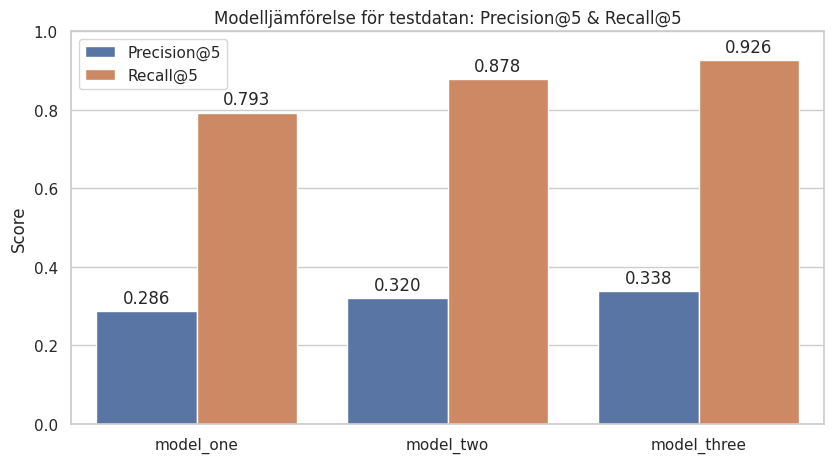

,Model,Precision@5,Recall@5,F1@5
0,model_one,0.286,0.793,0.421
1,model_two,0.320,0.878,0.469
2,model_three,0.338,0.926,0.496


In [185]:


def score_matrix(estimator, X):
    """
    Returnerar en (n_samples, n_labels)-matris med scores för ranking.
    Prioriterar predict_proba, annars decision_function.
    """
    if hasattr(estimator, "predict_proba"):
        scores = estimator.predict_proba(X)
    elif hasattr(estimator, "decision_function"):
        scores = estimator.decision_function(X)
    else:
        raise AttributeError(
            "Modellen saknar både predict_proba och decision_function."
        )

    return np.asarray(scores)


def precision_recall_at_k(y_true, y_scores, k=5):
    """
    Beräknar Precision@k och Recall@k (macro över samples).

    y_true   : binär matris (n_samples, n_labels)
    y_scores : score/proba-matris (n_samples, n_labels)
    """
    y_true = np.asarray(y_true).astype(int)
    y_scores = np.asarray(y_scores)

    n_samples, n_labels = y_true.shape
    k_eff = min(k, n_labels)

    if k_eff <= 0:
        raise ValueError("k måste vara >= 1 och minst en label måste finnas.")

    # Hitta index för top-k per rad (utan full sortering)
    topk_idx = np.argpartition(-y_scores, kth=k_eff - 1, axis=1)[:, :k_eff]

    # Bygg binär prediktionsmatris
    y_pred = np.zeros_like(y_true, dtype=int)
    rows = np.arange(n_samples)[:, None]
    y_pred[rows, topk_idx] = 1

    # Antal träffar per rad
    hits = (y_pred & (y_true == 1)).sum(axis=1)
    true_counts = y_true.sum(axis=1)

    # Macro över samples
    precision = (hits / k_eff).mean()
    recall = (hits / np.maximum(true_counts, 1)).mean()

    return float(precision), float(recall)


def f1_from_pr(p, r):
    return 0.0 if (p + r) == 0 else 2 * (p * r) / (p + r)

# Antal att ta med, sätter den till 5. Men gör den enkel att byta ut för att testa olika.
k = 5

# Beräkna score för respektive modell
scores_one = score_matrix(model_one, X_test_model_one)
p1, r1 = precision_recall_at_k(y_test, scores_one, k=k)

scores_two = score_matrix(model_two, X_test_model_two)
p2, r2 = precision_recall_at_k(y_test, scores_two, k=k)

scores_three = score_matrix(model_three, X_test_model_three)
p3, r3 = precision_recall_at_k(y_test, scores_three, k=k)


# Samlar resultaten i en ny dataframe
results = pd.DataFrame(
    {
        "Model": ["model_one", "model_two", "model_three"],
        f"Precision@{k}": [p1, p2, p3],
        f"Recall@{k}": [r1, r2, r3],
        f"F1@{k}": [f1_from_pr(p1, r1,), f1_from_pr(p2, r2), f1_from_pr(p3, r3)],
    }
)

# Visualisering BarPlot
sns.set_theme(style="whitegrid")

plot_df = results.melt(
    id_vars="Model",
    value_vars=[f"Precision@{k}", f"Recall@{k}"],
    var_name="Metric",
    value_name="Score",
)

fig, ax = plt.subplots(figsize=(8.5, 4.8))

sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric", ax=ax)

ax.set_title(f"Modelljämförelse för testdatan: Precision@{k} & Recall@{k}")
ax.set_xlabel("")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)

ax.legend(title="")
plt.tight_layout()
plt.show()

# Visar resultat-tabell
display(
    results.style.format(
        {
            f"Precision@{k}": "{:.3f}",
            f"Recall@{k}": "{:.3f}",
            f"F1@{k}": "{:.3f}",
        }
    )
)


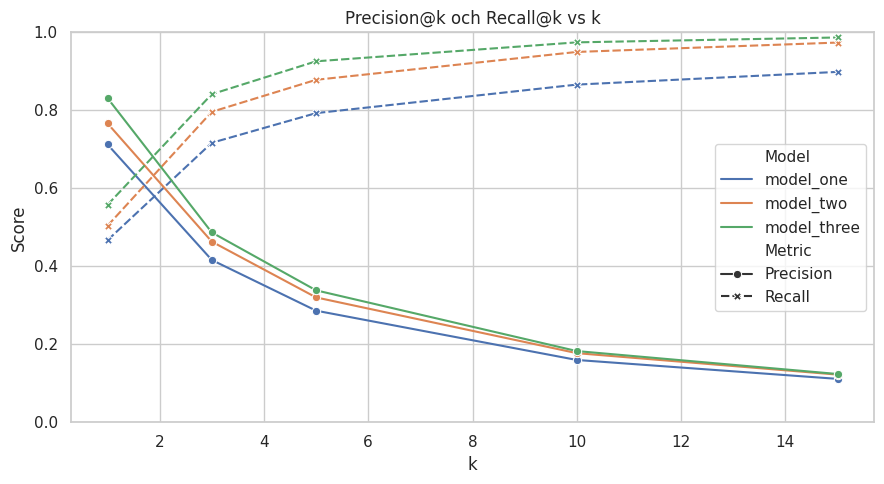

,k,Precision,Recall,F1,Model
0,1,0.712536,0.466800,0.564067,model_one
1,3,0.416186,0.716672,0.526578,model_one
2,5,0.286167,0.792802,0.420538,model_one
3,10,0.159726,0.865950,0.269705,model_one
4,15,0.111239,0.898545,0.197970,model_one
5,1,0.766571,0.503868,0.608058,model_two
6,3,0.463256,0.796139,0.585704,model_two
7,5,0.320173,0.878256,0.469271,model_two
8,10,0.177233,0.949712,0.298720,model_two
9,15,0.122190,0.973751,0.217134,model_two


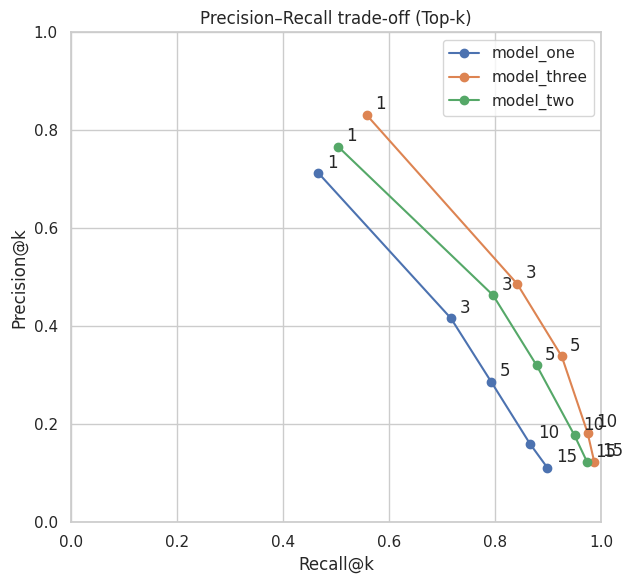

In [186]:
# Det skulle vara intressant att se resultaten vid val av olika k, alltså olika värden för hur många av de högst rankade keywordsen vi använder.
# Skapar ett diagram för detta och väljer vilka värden för k jag vill jämföra
k_values = [1, 3, 5, 10, 15]

def prf_over_k(model, X_test, y_test, k_values):
    scores = score_matrix(model, X_test)
    rows = []
    for k in k_values:
        p, r = precision_recall_at_k(y_test, scores, k=k)
        rows.append({"k": k, "Precision": p, "Recall": r, "F1": f1_from_pr(p, r)})
    return pd.DataFrame(rows)

df1 = prf_over_k(model_one, X_test_model_one, y_test, k_values)
df1["Model"] = "model_one"

df2 = prf_over_k(model_two, X_test_model_two, y_test, k_values)
df2["Model"] = "model_two"

df3 = prf_over_k(model_three, X_test_model_three, y_test, k_values)
df3["Model"] = "model_three"

prk_df = pd.concat([df1, df2, df3], ignore_index=True)

# Plot: Precision@k och Recall@k vs k
plot_long = prk_df.melt(id_vars=["Model", "k"], value_vars=["Precision", "Recall"],
                        var_name="Metric", value_name="Score")

fig, ax = plt.subplots(figsize=(9, 5))
sns.lineplot(data=plot_long, x="k", y="Score", hue="Model", style="Metric", markers=True, ax=ax)
ax.set_title("Precision@k och Recall@k vs k")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

display(prk_df)

fig, ax = plt.subplots(figsize=(6.5, 6))

for mname, d in prk_df.groupby("Model"):
    ax.plot(d["Recall"], d["Precision"], marker="o", label=mname)
    # Annotera varje punkt med k
    for _, row in d.iterrows():
        ax.annotate(str(int(row["k"])), (row["Recall"], row["Precision"]),
                    textcoords="offset points", xytext=(6, 4))

ax.set_title("Precision–Recall trade-off (Top-k)")
ax.set_xlabel("Recall@k")
ax.set_ylabel("Precision@k")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(title="")
plt.tight_layout()
plt.show()

### Analys och diskussion

#### Modelljämförelse

Syftet med projektet är att undersöka hur väl olika modeller kan föreslå relevanta keywords baserat på textdata. Tre huvudsakliga modelleringar har genomförts, där model_one, model_two och model_three successivt utvecklats genom förändringar i representationen av X-variabeln.

Resultaten visar en tydlig och konsekvent förbättring mellan modellerna. Model_two presterar bättre än model_one, och model_three presterar bäst av samtliga modeller enligt de utvärderingsmått som använts (Precision@5, Recall@5 och F1@5).

Visualiseringarna visar tydligt att model_three uppnår högst Recall@5 (0.926) samtidigt som Precision@5 också förbättras jämfört med tidigare modeller. Detta indikerar att den struktur som används för X-variabeln i model_three är mer informativ och bättre anpassad för uppgiften. Förbättringen sker inte bara i Recall utan även i Precision, vilket tyder på att modellen inte enbart genererar fler förslag utan faktiskt förbättrar sin rankingförmåga.

Detta motiverar vidare undersökningar, exempelvis genom att ytterligare dela upp textsträngarna så att de blir separata variabler och därmed potentiellt ökar signalstyrkan i indata. Samtidigt visar resultaten att sannolikheten att minst ett korrekt keyword finns bland de föreslagna är mycket hög. Givet projektets syfte och användningsområde bedömer jag därför att modelleringen är tillräckligt robust för att gå vidare mot ett produktionssteg.

#### Diskussion om resultat

Ett tydligt mönster i resultaten är att ju högre k-värde som används, desto högre blir Recall medan Precision minskar. Detta är både logiskt och förväntat. När modellen tillåts föreslå fler keywords ökar sannolikheten att inkludera det korrekta keywordet (ökad Recall), men samtidigt ökar andelen irrelevanta förslag (minskad Precision).

Det bästa precisionvärdet uppnås nästan när modellen endast föreslår ett keyword. Detta visar att modellen är mest säker i sitt högst rankade förslag. Samtidigt är det i praktiken ofta så att fler än ett keyword är relevant för en produkt. Därför är det rimligt att visa upp till exempelvis fem förslag när modellen används som beslutsstöd för en berikare.

Sammantaget visar resultaten att model_three är den mest balanserade och mest praktiskt användbara modellen i nuvarande utförande, samtidigt som det finns utrymme för ytterligare optimering genom mer avancerad feature engineering och vidare experimentering.

Om modellen däremot skulle användas för automatisk keyword-sättning utan mänsklig granskning hade det varit mer lämpligt att endast returnera det högst rankade keywordet, där Precision är som högst. Detta visar att optimal modellkonfiguration är beroende av användningsområde och inte enbart av numeriska utvärderingsmått. Det här scenariot är inte troligt för företaget jag arbetar på. Vi strävar alltid efter att ha ett efterföljande steg där en berikare kontrollerar fakta, korrekturläser samt säkerställer att alla relevanta keywords finns för produkten.

#### Diskussion om ML-projektet

Arbetet med projektet har tydliggjort att maskininlärning i praktiken är en iterativ process snarare än en linjär sådan. Flera delar av arbetet – särskilt representationen av X-variabeln – har haft större påverkan på resultatet än valet av själva modelltypen. Det bekräftar att datans struktur och kvalitet ofta är viktigare än modellens komplexitet. Jag fick lägga mycket mer tid än vad jag trodde på själva datahanterandet.

En aha-upplevelse för mig blev att förbättringarna mellan model_one, model_two och model_three skiljde sig åt tydligt och inte berodde på mängden indata, utan snarare på att justerandet av features gav en tydlig förbättring. Det visar verkligen vikten av feature engineering och genomtänkt databehandling. Att dela upp textsträngar och strukturera information mer granularärt visade sig ge en märkbar effekt på både Precision och Recall, i alla fall för mitt lilla projekt.

En annan viktig insikt är att modellens kvalitet inte kan bedömas isolerat från dess användningsområde. Precision och Recall måste tolkas i relation till hur modellen faktiskt ska användas. En modell med hög Recall men lägre Precision kan vara mycket användbar som beslutsstöd, men olämplig för helautomatiserade beslut. Den insikten gav mig att utvärderingen också är ett verktyg för bedömning av lämpligheten i kommande användning av modellen.

Projektet har också tydliggjort precision–recall-tradeoffens praktiska betydelse. Att öka k-värdet förbättrar träffsäkerheten i termer av täckning, men reducerar träffsäkerheten per förslag. 

Slutligen tar jag med mig att det verkligen har varit, och kommer fortsatt vara, en iterativ process. Även fast jag förstått det från boken, och de exempel jag skrivit ned och testat så, så var det först genom att arbeta igenom ett eget ML-projekt inom ett område där jag har djup branschkunskap som jag såg vidden av det. Visar också på att branschkunskap och förförståelse är otroligt viktigt. Skulle jag jobbat inom ett område där jag var novis hade förberedelserna behövt vara mycket mer omfattande.